# Présentations de fonctions utiles lors de l'analyse multi-vols

Projet de statistiques descriptives MACS3, dans le cadre du cours de Jérôme Lacaille.

_Version 1.0 [27/11/2023] Kraemer Valentin_

## Présentation des fonctions d'analyses de dask.dataframe & application au cas classique $N1 = N2 + T1$

### Présentation des fonctionnnalités proposées 

Ce notebook a pour objectif de présenter certaines fonctions basées sur le package *dask* pour paralléliser les analyses sur tous les vols d'un même avion. On commencera celui-ci en présentant une analyse déjà vue en cours, à savoir le N1 en fonction du N2 et de la température.


**Importation des modules pour l'analyse**

In [2]:
%reload_ext autoreload
%autoreload 2

# packages utiles 
import sys, glob, re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson

# module
sys.path.append("../")
from src import lire_hdf_dask

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Récupération de la donnée**

In [3]:
# chemin vers la donnee 
data_dir = '/home/valentin/Documents/Cours/MACS/MACS3/madane/data/data_extracted/'
filelist = glob.glob(data_dir + '*.h5')

# PARAMETRES DE LA DONNEE 
# Avion
_PLANE = 0
ddf = lire_hdf_dask(filelist[_PLANE], repertoire= data_dir)

#### Implémentation de fonctions d'automatisation 

1. Fonction de normalisation de la donnée 

En enlevant les différentes variables boléennes pouvant admettre des divisions par zéro et dont la normalisation n'a pas de sens (pb de type), ainsi qu'en renommant les variables sans leur unités (pour éviter les crochets pour des raisons d'incompatibilités dans les régressions), on définit alors la fonction normalize ci-contre :

In [4]:
def normalize(df, l = ['NAIV_1 [bool]', 'NAIV_2 [bool]','PRV_1 [bool]', 'PRV_2 [bool]']):
    """
    @author : Kraemer Valenitn 
    normalize function 

    desc : élimination des valeurs boléennes du dataframe de vol et renommage des variables sans les crochets d'unité par souci de comptatibilité python

    Input : 
        df : dataframe d'un vol 
        l  : (facultatif) liste des colonnes à supprimer du dataframe pour éviter notamment les divisions par zéro

    Output : 
        df_norm : dataframe normalisé. 
    """
    if len(l)!=0 :
        df=  df.drop(columns = l)
    newname = []
    for col in df.columns :
        newname.append(re.sub(r' \[.*?\]', '', col))
    X = df.values
    X_norm = (X - np.mean(X,axis = 0))/np.std(X, axis = 0)
    df_norm = pd.DataFrame(data = X_norm, columns=newname, index= df.index)

    return df_norm

Ainsi, le package dask nous permet d'obtenir un dask.dataframe normalisé avant la ligne suivante :

In [5]:
ddf_norm = ddf.map_partitions(lambda df : normalize(df))

/tmp/ipykernel_70691/1180120115.py:21: RuntimeWarning: invalid value encountered in divide
  X_norm = (X - np.mean(X,axis = 0))/np.std(X, axis = 0)


Par ailleurs, on définit également une fonction de renommage pour une application non normalisée. 

In [6]:
def rename(df):
    """
    @author : Kraemer Valenitn 
    rename function 

    desc : élimination des valeurs boléennes du dataframe de vol et renommage des variables sans les crochets d'unité par souci de comptatibilité python

    Input : 
        df : dataframe d'un vol 

    Output : 
        df_norm : dataframe sans les brackets des unités. 
    """

    newname = []
    for col in df.columns :
        newname.append(re.sub(r' \[.*?\]', '', col))
    X = df.values
    df_norm = pd.DataFrame(data = X, columns=newname, index= df.index)

    return df_norm

On obtient ainsi un dataframe renommé avec la ligne suivante : 

In [7]:
ddf = ddf.map_partitions(lambda df : rename(df))

2. Fonction de regression multi-vols

On réalise une surcouche de la fonction **ols** de *statsmodel* afin de stocker ces résultats dans un dictionnaire, dans le but de simplifier la procédure de traitement et d'affichage par la suite.

Ainsi, la fonction regression s'écrit de la manière suivante :

In [8]:
def regression(df, formula) :
    """
    @author : Kraemer Valentin 
    regression function 

    desc : fonction d'automatisation de la regression utilisable compatible avec la fonction generate_df_reg pour une implémentation sous dask

    Input : 
        df : dataframe d'étude 
        formula : la formule de regression à appliquer
    
    Output : 
        reg_dict : un dictionnaire contenant les informations nécessaires à une analyse multi-vol à savoir 
            - le R2 de regression                       (R2)
            - le nombre d'observation                   (N_observations)
            - le test de durbin waston                  (Durbin_Watson)
            - la liste des paramètres de regression     (ParamName)
            - les valeurs des paramètres de regression  (Paramètres)
            - la pvaleur de chaque paramètres           (pvaleur)
            - les intervalles de confiances de chq prm  (Intervals)

    """
    df2 = df.copy()
    import re 
    for col in df.columns :
        newname = re.sub(r' \[.*?\]', '', col)
        df2.rename(columns={col:newname}, inplace=True)
    model = ols(formula, data = df2).fit()
    r2 = model.rsquared
    pvals = model.pvalues
    IC = model.conf_int(0.05)
    n_obs = model.nobs
    params_list = model.params
    reg_dict = {'R2' :r2, 'pvaleur' : pvals.values, 'N_observations':n_obs, 'Paramètres' : params_list.values, 'Intervals': IC.values, 'ParamName': list(params_list.index) , 'Durbin_Watson' : durbin_watson(model.resid)}
    return reg_dict

Rien d'exceptionnel pour le moment.. l'intérêt de cette fonction se trouve dans l'application suivante :

En se donnant la formule de regression sur le N1, N2 en fonction de la température, on obtient :

In [9]:
# formule de regression
formula = "N1_1 ~ N2_1 + T1_1 "

# application de la regression a tous les vols
all_reg = ddf_norm.map_partitions(lambda df : regression(df, formula)).compute()
all_reg

/home/valentin/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/valentin/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


0       {'R2': 0.8455468411716484, 'pvaleur': [0.99999...
1       {'R2': 0.8357235750300768, 'pvaleur': [0.99999...
2       {'R2': 0.7934484495280593, 'pvaleur': [0.99999...
3       {'R2': 0.8029321180664897, 'pvaleur': [0.99999...
4       {'R2': 0.81280552882417, 'pvaleur': [0.9999999...
                              ...                        
997     {'R2': 0.7934391419675324, 'pvaleur': [0.99999...
998     {'R2': 0.791572572199936, 'pvaleur': [0.999999...
999     {'R2': 0.8276093416294155, 'pvaleur': [0.99999...
1000    {'R2': 0.7761360468392849, 'pvaleur': [0.99999...
1001    {'R2': 0.798972385385081, 'pvaleur': [0.999999...
Length: 1002, dtype: object

On obtient alors un objet python contenant l'ensemble des dictionnaires obtenus à partir de la fonction de régression précédente. On souhaiterait stocker ces regressions sous la forme d'un dataframe afin de faciliter son analyse et afficher des résultats. 

Ainsi, on implémente la fonction *generate_df_reg* pour passer le résultat de *all_reg* dans un dataframe :


In [10]:
def generate_df_reg (all_reg):
    """
    @author : Kraemer Valentin 
    generate_df_reg function 

    desc : génération d'un dataframe contenant les analyses regressives d'un avion sur tous ses vols

    Input : 
        all_reg : liste de dictionnaire de la forme de l'output de manipulate_dataframe.regression;
            -> celui ci provient de la sortie de la computation de dask.map_partition(lambda df: regression(df))
    
    Output : 
        dataframe contenant toutes les analyses regressives de all_reg stockées sous forme de dataframe pour une meilleure manipulation    
    """
    records = all_reg.index.values
    Params = all_reg[0]['ParamName']
    R2 = np.empty(len(records))
    N_obs= np.empty(len(records))
    pvals = np.empty((len(records), len(Params)))
    params_val = np.empty((len(records), len(Params)))
    IC_0 =  np.empty((len(records), len(Params)))
    IC_1 =  np.empty((len(records), len(Params)))
    DurbinWatson =  np.empty(len(records))

    for i, record in enumerate(records) :
        record_dict = all_reg[record]
        R2[i] = record_dict['R2']
        N_obs[i] = record_dict['N_observations']
        pvals[i, :] = record_dict['pvaleur']
        params_val[i, :] = record_dict['Paramètres']
        IC_0[i,:] = record_dict['Intervals'][:,0]
        IC_1[i,:] = record_dict['Intervals'][:,1]
        DurbinWatson[i] = record_dict['Durbin_Watson']

    df_reg = pd.DataFrame({'record': records, 'R2': R2, 'N_obs': N_obs, 'Durbin_Waston': DurbinWatson}).set_index('record')
    for i, param in enumerate(Params) :
        df_reg['coeff_'+param] = params_val[:,i]
        df_reg['pval_'+param] = pvals[:,i]
        df_reg['IC0_'+param] = IC_0[:,i]
        df_reg['IC1_'+param] = IC_1[:,i]

    return df_reg


On obtient alors :

In [11]:
df_reg = generate_df_reg(all_reg)
df_reg

,R2,N_obs,Durbin_Waston,coeff_Intercept,pval_Intercept,IC0_Intercept,IC1_Intercept,coeff_N2_1,pval_N2_1,IC0_N2_1,IC1_N2_1,coeff_T1_1,pval_T1_1,IC0_T1_1,IC1_T1_1
record,,,,,,,,,,,,,,,
0,0.845547,9124.0,0.002711,-1.026956e-15,1.0,-0.008066,0.008066,0.536795,0.0,0.526922,0.546667,-0.498700,0.0,-0.508573,-0.488827
1,0.835724,8925.0,0.002342,1.020378e-15,1.0,-0.008411,0.008411,0.513300,0.0,0.502714,0.523886,-0.506493,0.0,-0.517079,-0.495907
2,0.793448,6192.0,0.001367,-3.816392e-17,1.0,-0.011325,0.011325,0.609641,0.0,0.596399,0.622883,-0.406288,0.0,-0.419530,-0.393046
3,0.802932,6383.0,0.001964,1.357421e-16,1.0,-0.010895,0.010895,0.599876,0.0,0.587566,0.612185,-0.442619,0.0,-0.454929,-0.430310
4,0.812806,5428.0,0.001782,6.661338e-16,1.0,-0.011516,0.011516,0.565975,0.0,0.551570,0.580379,-0.439792,0.0,-0.454197,-0.425388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,0.793439,5755.0,0.003462,-2.623769e-16,1.0,-0.011748,0.011748,0.580235,0.0,0.566120,0.594351,-0.426818,0.0,-0.440934,-0.412703
998,0.791573,5695.0,0.003167,-6.266689e-16,1.0,-0.011863,0.011863,0.614049,0.0,0.600468,0.627630,-0.410896,0.0,-0.424477,-0.397315
999,0.827609,8130.0,0.002626,6.590865e-16,1.0,-0.009028,0.009028,0.585644,0.0,0.575661,0.595627,-0.489760,0.0,-0.499743,-0.479778


On définit alors les fonctions suivante : 

- afficher_significativite : permettant d'obtenir le $R^2$ de regression ainsi que le nombre de points d'études que l'on a apris en fonction du numéro de vol 

- afficher_coeff : qui affiche les coefficients de régressions en fonction du numéro de vol

Ces fonctions sont implémentées de la manière suivante :

In [12]:
def afficher_significativite(df_reg) :
    """
    afficher_siginificativite function 
    @author : Kraemer Valentin 

    Input : df_reg : dataframe de regression multi-vols

    Output : None

    """
    records = df_reg.index.values
    fig, axs = plt.subplots(2, figsize = (10,8))
    axs[0].plot(records, df_reg['R2'].values)
    axs[1].plot(records, df_reg['N_obs'].values)
    axs[0].set_xlabel('records')
    axs[0].set_ylabel('R2')
    axs[0].set_ylim((0,1))
    axs[1].set_xlabel('records')
    axs[1].set_ylabel("Nombre d'observations")

    plt.show()


def afficher_coeff(df_reg,window = 1, tol = 1e-10, norm= True):
    """
    afficher_coeff function
    @author : Kraemer Valentin 

    Input : 
        df_reg : dataframe de regression multi-vols
        window : (default = 1) la fenetre glissante surlaquelle on applique une mediane glissante
        tol    : (default = 1e-10) la tolérance au delà de laquelle on n'affiche plus les coefficients car la p-valeur est trop élevée
        norm   : (bolean, default = True) : permet d'afficher_coeff avec un y_range compris entre -1 et 1 dans le cas de données normalisées
    """
    l= df_reg.columns
    ParamName = [s.split('coeff_')[1] for s in l if 'coeff_' in s]
    idx = df_reg.index.values
    plt.figure(figsize=(10, 8))
    for i,param in enumerate(ParamName) :
        df_param =df_reg.where(df_reg['pval_'+param]<tol)
        y_roll = df_param['coeff_'+param].rolling(window=window).median().values
        y_up = df_param['IC1_'+param].rolling(window= window).median().values
        y_down = df_param['IC0_'+param].rolling(window= window).median().values
        # mettre à NAN si la p_valeur depasse un certain seuil 
        plt.plot(idx, y_roll, label = param)
        plt.fill_between(idx,y_up, y_down, alpha = 0.2)
    plt.xlabel('record')
    plt.ylabel('coefficient de regression')
    if norm == True : plt.ylim((-1,1))
    plt.legend()
    plt.show()

**Exemple d'application**



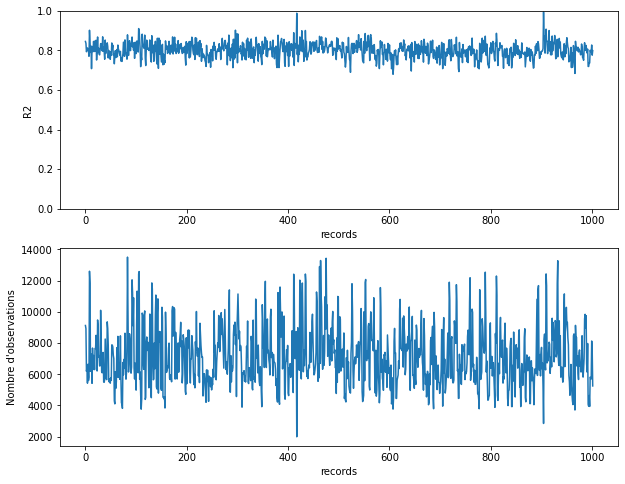

In [13]:
afficher_significativite(df_reg)

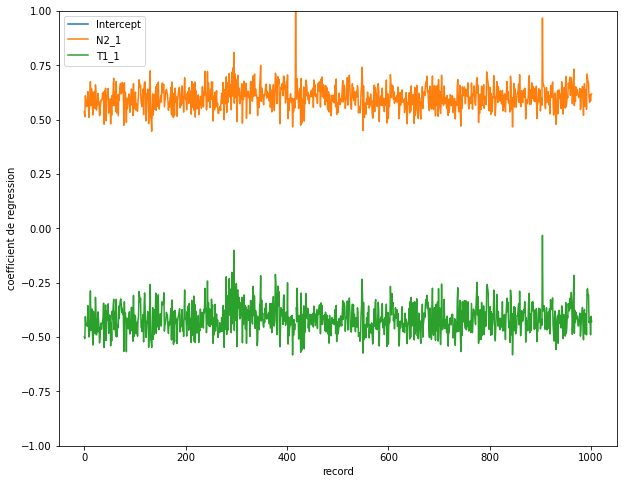

In [14]:
afficher_coeff(df_reg)

NB : Pour le dask.dataframe non normalisé, on obtient le résultat suivant :

In [15]:
# formule de regression
formula = "N1_1 ~ N2_1 + T1_1 "

# application de la regression a tous les vols
all_reg_no_norm = ddf.map_partitions(lambda df : regression(df, formula)).compute()

# dataframe de regression
df_reg_no_norm = generate_df_reg(all_reg_no_norm)

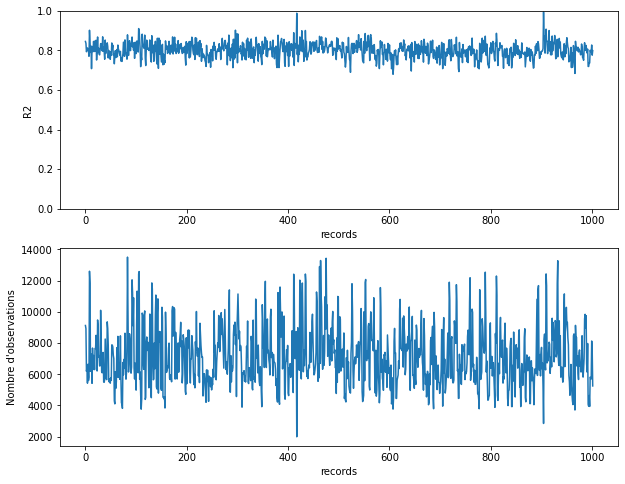

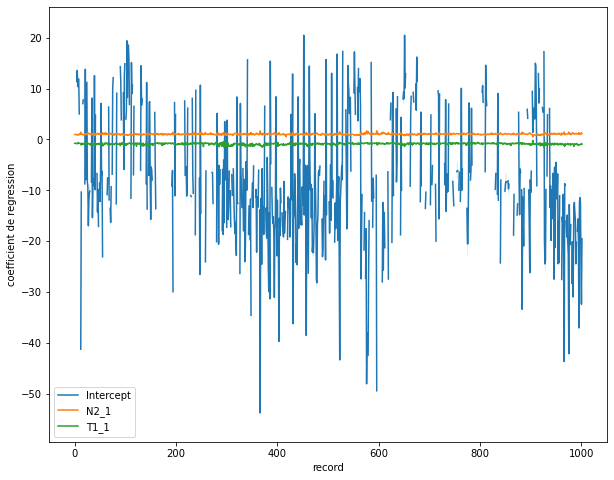

In [16]:
# affichage en sortie 
afficher_significativite(df_reg_no_norm)
afficher_coeff(df_reg_no_norm, norm = False)

Dans le cas des données non normalisées, on constate de l'importance significative (en amplitude !) de la valeur de l'ordonnée à l'origine, ne permettant pas d'apprécier de manière qualitative de l'évolution des paramètres de regression (autres que l'intercept) au cours des vols. On s'interessera alors à une amélioration de cette fonction d'affichage sur deux graphes différents.

In [17]:

def afficher_coeff(df_reg,window = 1, tol = 1e-10, norm= True):
    """
    afficher_coeff function
    @author : Kraemer Valentin 

    Input : 
        df_reg : dataframe de regression multi-vols
        window : (default = 1) la fenetre glissante surlaquelle on applique une mediane glissante
        tol    : (default = 1e-10) la tolérance au delà de laquelle on n'affiche plus les coefficients car la p-valeur est trop élevée
        norm   : (bolean, default = True) : permet d'afficher_coeff avec un y_range compris entre -1 et 1 dans le cas de données normalisées
    """
    
    l= df_reg.columns
    ParamName = [s.split('coeff_')[1] for s in l if 'coeff_' in s]
    if norm != True : ParamName.remove('Intercept')
    idx = df_reg.index.values
    plt.figure(figsize=(10, 8))
    for i,param in enumerate(ParamName) :
        df_param =df_reg.where(df_reg['pval_'+param]<tol)
        y_roll = df_param['coeff_'+param].rolling(window=window).median().values
        y_up = df_param['IC1_'+param].rolling(window= window).median().values
        y_down = df_param['IC0_'+param].rolling(window= window).median().values
        plt.plot(idx, y_roll, label = param)
        plt.fill_between(idx,y_up, y_down, alpha = 0.2)
    plt.xlabel('record')
    plt.ylabel('coefficient de regression')
    if norm == True : plt.ylim((-1,1))
    plt.legend()    
    plt.show()
    if norm != True : 
        plt.figure(figsize=(10, 8))
        param = 'Intercept'
        df_param =df_reg.where(df_reg['pval_'+param]<tol)
        y_roll = df_param['coeff_'+param].rolling(window=window).median().values
        y_up = df_param['IC1_'+param].rolling(window= window).median().values
        y_down = df_param['IC0_'+param].rolling(window= window).median().values
        plt.plot(idx, y_roll, label = param)
        plt.fill_between(idx,y_up, y_down, alpha = 0.2)
        plt.xlabel('record')
        plt.ylabel('coefficient de regression')
        plt.legend()    
        plt.show()


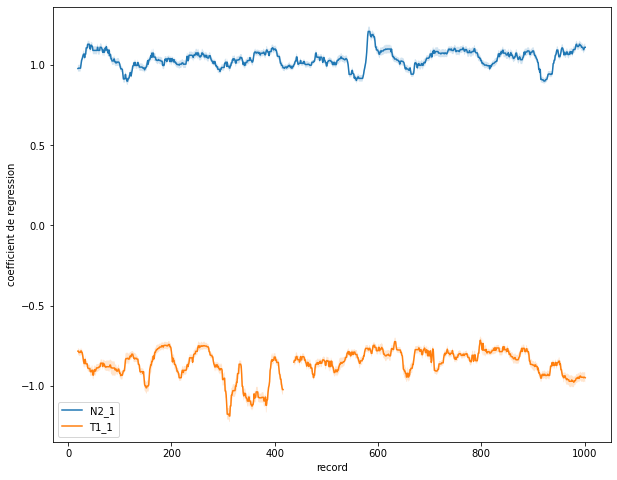

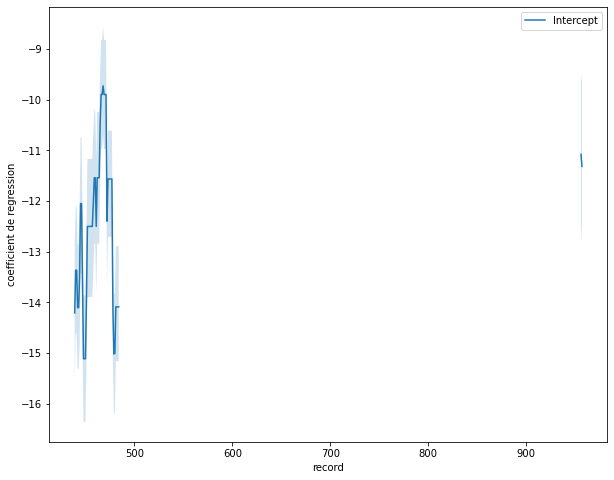

In [19]:
afficher_coeff(df_reg_no_norm, norm = False, window = 20)

### Discussion : Pourquoi avoir implémenté ces fonctions ? 

Lors de la création de cette méthode, j'ai souhaité étudier la variation des coefficients de regression en fonction de l'utilisation du moteur. Supposé neuf à l'origine, le comportement physique entre les différentes pièces pourrait évoluer en fonction du temps : ainsi, les coefficients de regressions pourraient avoir tendance à décroitre ou croitre significativement. 

Par ailleurs, cette méthode nous permet d'améliorer considérablement nos prédictions de comportement des différentes variables pour la simulation. En effet, ces coefficients de regressions étant sensiblement constant au cours des vols, on peut alors poser :

$$
N_{1,norm} = \alpha N_{2, norm} + \beta T_{1, norm}
$$
avec $\alpha = mean(\alpha_{reg})$ et $\beta = mean(\beta_{reg})$, des valeurs connues et constantes !

Ainsi, il suffit de revenir à $N_1$ non normalisé avec un estimateur de variance et de moyenne pour obtenir une prédiction de $N_1$ au cours du temps. 

En outre, si les parmètres $\alpha$ et $\beta$ dépendent du nombre de vol effectué, on peut alors obtenir des résultats plus intéressant qu'une statistique de regression triviale. 